In [1]:
import pandas as pd
import numpy as np
import cmdstanpy as stan
import matplotlib.pyplot as plt
from scipy import stats

from modelling.util.data_loader import load_data, drop_dummy_cols

/Users/leevi/.pyenv/versions/3.10.0/envs/bda-venv/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df = load_data(include_dummies=True, effect_coding=False, norm_data=True)

In [3]:
df.columns

Index(['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak', 'sex',
       'chest_pain_type', 'fasting_bs', 'resting_ecg', 'exercise_angina',
       'st_slope', 'heart_disease', 'resting_ecg_normal', 'resting_ecg_st',
       'resting_ecg_lvh', 'chest_pain_type_ata', 'chest_pain_type_nap',
       'chest_pain_type_asy', 'chest_pain_type_ta', 'st_slope_up',
       'st_slope_flat', 'st_slope_down'],
      dtype='object')

In [4]:
df.groupby('sex').heart_disease.agg(['count', 'mean'])

,count,mean
sex,,
0,193,0.259067
1,725,0.631724


In [5]:
df.groupby('chest_pain_type').heart_disease.agg(['count', 'mean'])

,count,mean
chest_pain_type,,
ASY,496,0.790323
ATA,173,0.138728
NAP,203,0.354680
TA,46,0.434783


In [6]:
df.groupby('fasting_bs').heart_disease.agg(['count', 'mean'])

,count,mean
fasting_bs,,
0,704,0.480114
1,214,0.794393


In [7]:
df.groupby('resting_ecg').heart_disease.agg(['count', 'mean'])

,count,mean
resting_ecg,,
LVH,188,0.563830
Normal,552,0.516304
ST,178,0.657303


In [8]:
df.groupby('exercise_angina').heart_disease.agg(['count', 'mean'])

,count,mean
exercise_angina,,
0,547,0.351005
1,371,0.851752


In [9]:
df.groupby('st_slope').heart_disease.agg(['count', 'mean'])

,count,mean
st_slope,,
Down,63,0.777778
Flat,460,0.828261
Up,395,0.197468


# Set up simple logistic regression model

In [10]:
from modelling.util.data_formatters import format_logreg_data
simple_data = format_logreg_data(df)
simple_priors = dict(
    alpha_mu = 0,
    alpha_scale = 1,
    beta_mu = np.zeros(simple_data['M']),
    beta_scale = np.ones(simple_data['M']),
)
simple_input = simple_data | simple_priors

In [11]:
simple_model = stan.CmdStanModel(stan_file='modelling/stan_models/simple_regression.stan')
fit = simple_model.sample(simple_input)
summary = fit.summary()
summary.filter(regex=r'(alpha|beta)', axis=0)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/leevi/repos/bda-project/modelling/stan_models/simple_regression
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
beta[1],0.160,0.0019,0.12,-0.047,0.160,0.360,4252.0,1031.0,1.0
beta[2],0.078,0.0016,0.11,-0.100,0.077,0.260,4702.0,1140.0,1.0
beta[3],-0.460,0.0018,0.12,-0.650,-0.460,-0.270,4423.0,1073.0,1.0
beta[4],-0.130,0.0020,0.13,-0.340,-0.130,0.077,3917.0,950.0,1.0
beta[5],0.410,0.0020,0.13,0.210,0.410,0.620,4005.0,971.0,1.0
beta[6],1.300,0.0037,0.26,0.900,1.300,1.800,4892.0,1187.0,1.0
beta[7],1.100,0.0038,0.26,0.640,1.100,1.500,4425.0,1073.0,1.0
beta[8],0.870,0.0036,0.24,0.480,0.880,1.300,4352.0,1056.0,1.0
beta[9],-0.380,0.0120,0.53,-1.200,-0.390,0.480,1955.0,474.0,1.0


# Hierarchical model

In [11]:
def format_hierarchical_data(df, grouping_cols):
    y_name = 'heart_disease'
    y = df[y_name]

    df = df.drop(columns=[y_name])
    df = drop_dummy_cols(df, grouping_cols)
    df_numeric = df.select_dtypes(include=['int64','float64'])
    df_numeric = df_numeric.drop(columns=grouping_cols, errors='ignore')
    group_indicies = df.groupby(grouping_cols).ngroup() + 1
    mapping_index = pd.MultiIndex.from_frame(df[grouping_cols])
    group_indicies.index = mapping_index
    X = df_numeric
    N, M = X.shape
    data = dict(
        N=N,
        M=M,
        y=y,
        X=X,
        J=group_indicies.max(),
        gj=group_indicies,
        index_mapping=group_indicies.drop_duplicates()
    )
    return data

In [12]:
from modelling.util.data_formatters import format_hierarchical_data

In [13]:
hier_data = format_hierarchical_data(df, ['chest_pain_type'])
hier_priors = dict(
    am_mu = 0,
    am_scale = 1,
    bm_mu = np.zeros(hier_data['M']),
    bm_scale = np.ones(hier_data['M']),
    as_mu = 0,
    as_scale = 1,
    bs_mu = np.zeros(hier_data['M']),
    bs_scale = np.ones(hier_data['M']),
)
# hier_priors = dict(
#     am_mu = 0,
#     am_scale = 1,
#     bm_mu = np.zeros(hier_data['M']),
#     bm_scale = np.ones(hier_data['M']),
#     as_mu = 0,
#     as_scale = 1,
#     bs_mu = 0,
#     bs_scale = 1,
# )
hier_input = hier_data | hier_priors

In [21]:
type(hier_input['X'])

pandas.core.frame.DataFrame

In [24]:
hier_input['index_mapping'].to_dict()

{'chest_pain_type': {1: 'ASY', 2: 'ATA', 3: 'NAP', 4: 'TA'}}

In [26]:
import pickle

In [32]:
with open('hier.pkl', 'wb') as f:
    pickle.dump(hier_data, f)


In [33]:
with open('hier.pkl', 'rb') as f:
    out = pickle.load(f)

In [14]:
hier_model = stan.CmdStanModel(
    stan_file='modelling/stan_models/hierarchical_v5.stan',
    cpp_options={"STAN_THREADS": True})
hier_fit = hier_model.sample(
    hier_input,
    show_progress='notebook',
    output_dir='./logs',
    iter_sampling=4000,
    threads_per_chain=4)
hier_summary = hier_fit.summary()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/leevi/repos/bda-project/modelling/stan_models/hierarchical_v5


ValueError: Invalid type provided to write_stan_json for key 'index_mapping' as part of collection <class 'pandas.core.frame.DataFrame'>

In [99]:
hier_data['gj'].value_counts()

1    496
3    203
2    173
4     46
dtype: int64

In [100]:
hier_summary['R_hat'].max()

1.0

In [20]:
hier_fit.stan_variables().keys()

dict_keys(['alpha_mu', 'alpha_sigma', 'beta_mu', 'beta_sigma', 'alpha', 'beta'])

In [25]:
hier_summary.filter(regex=r'(alpha|beta)\[', axis=0)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],-0.600,0.0230,0.77,-1.9000,-0.620,0.670,1108.0,5.00,1.0
alpha[2],-1.300,0.0260,0.83,-2.7000,-1.300,0.004,982.0,4.40,1.0
alpha[3],-1.200,0.0500,0.80,-2.5000,-1.200,0.130,259.0,1.20,1.0
alpha[4],-1.000,0.0430,0.84,-2.3000,-1.000,0.310,376.0,1.70,1.0
"beta[1,1]",0.078,0.0045,0.16,-0.1900,0.089,0.320,1239.0,5.60,1.0
"beta[1,2]",0.068,0.0033,0.14,-0.1600,0.071,0.290,1791.0,8.10,1.0
"beta[1,3]",-0.530,0.0083,0.15,-0.7800,-0.530,-0.280,327.0,1.50,1.0
"beta[1,4]",0.037,0.0180,0.18,-0.2500,0.027,0.370,104.0,0.47,1.0
"beta[1,5]",0.510,0.0034,0.16,0.2500,0.510,0.770,2049.0,9.20,1.0


In [105]:
beta = hier_fit.stan_variables()['beta']

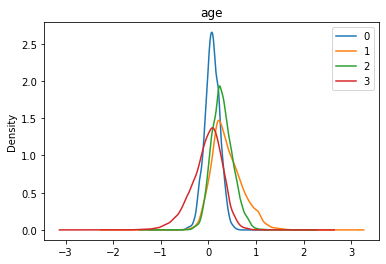

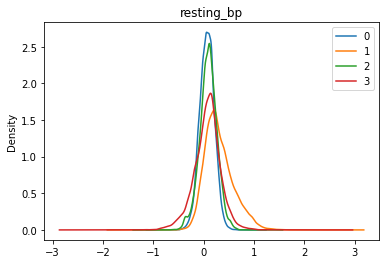

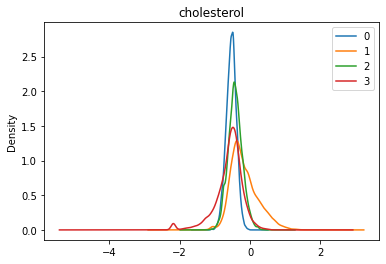

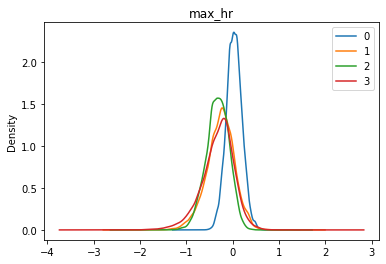

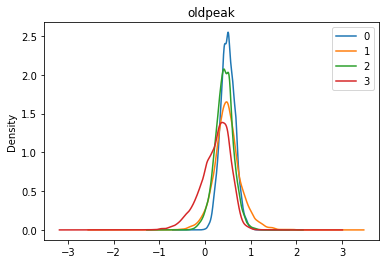

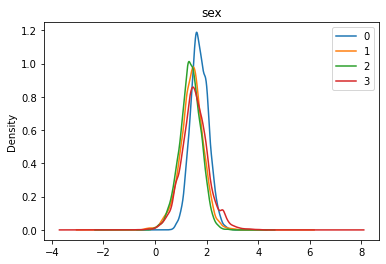

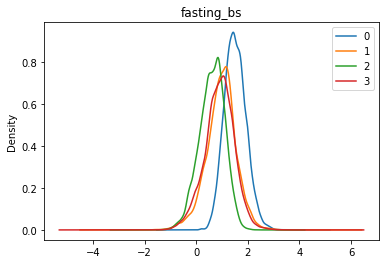

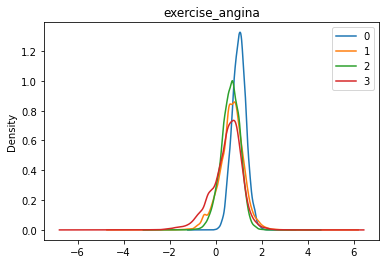

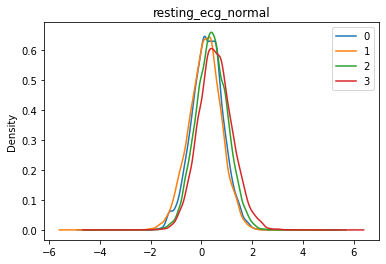

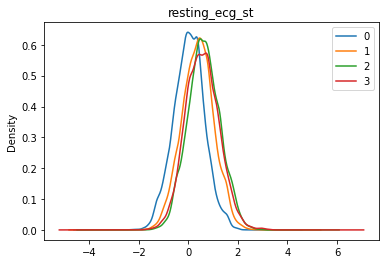

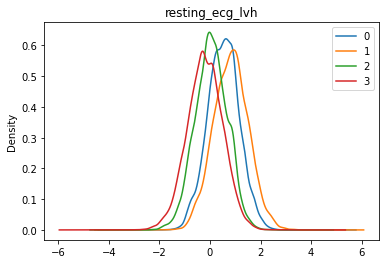

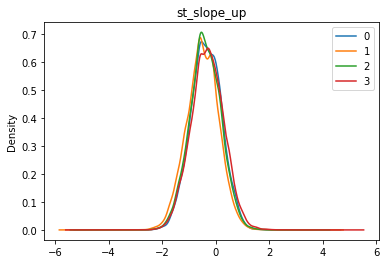

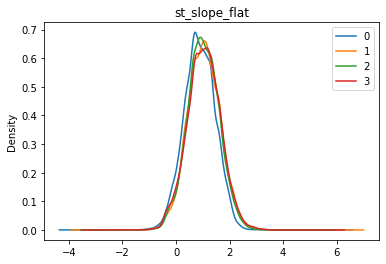

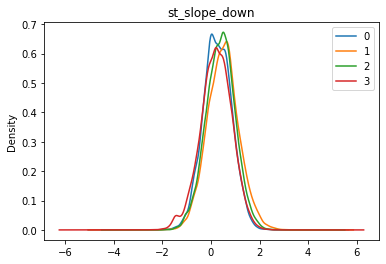

In [117]:
for i in range(beta.shape[2]):
    title = hier_input['X'].columns[i]
    pd.DataFrame(beta[:, : , i]).plot.kde(title=title);

In [90]:
hier_summary.StdDev.values

array([12.  ,  0.71,  0.44,  0.26,  0.22,  0.29,  0.27,  0.31,  0.42,
        0.45,  0.43,  0.57,  0.59,  0.59,  0.57,  0.57,  0.56,  0.3 ,
        0.26,  0.33,  0.31,  0.3 ,  0.38,  0.41,  0.39,  0.36,  0.37,
        0.4 ,  0.29,  0.29,  0.35,  0.78,  0.81,  0.79,  0.85,  0.17,
        0.15,  0.15,  0.18,  0.16,  0.34,  0.41,  0.3 ,  0.6 ,  0.61,
        0.61,  0.57,  0.58,  0.58,  0.31,  0.29,  0.4 ,  0.3 ,  0.34,
        0.47,  0.59,  0.5 ,  0.62,  0.64,  0.67,  0.61,  0.6 ,  0.63,
        0.23,  0.17,  0.2 ,  0.24,  0.22,  0.42,  0.48,  0.41,  0.6 ,
        0.64,  0.61,  0.59,  0.59,  0.59,  0.31,  0.25,  0.37,  0.34,
        0.32,  0.51,  0.59,  0.66,  0.66,  0.67,  0.7 ,  0.61,  0.61,
        0.65])

In [82]:
fit.summary().filter(regex=r'(alpha|beta)', axis=0)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
beta[1],0.150,0.0013,0.100,-0.017,0.150,0.31,6045.00,6363.00,1.0
beta[2],0.470,0.0011,0.093,0.320,0.470,0.62,7531.00,7928.00,1.0
beta[3],-0.011,0.0012,0.092,-0.160,-0.013,0.14,6067.00,6386.00,1.0
beta[4],-0.390,0.0014,0.100,-0.560,-0.390,-0.22,5898.00,6208.00,1.0
beta[5],0.520,0.0012,0.099,0.360,0.510,0.68,6701.00,7054.00,1.0
beta[6],-0.480,0.0013,0.100,-0.650,-0.480,-0.31,6139.00,6462.00,1.0
beta[7],0.830,0.0013,0.100,0.660,0.830,1.00,6218.00,6546.00,1.0
beta[8],0.760,0.0013,0.110,0.590,0.760,0.95,7111.00,7486.00,1.0
alpha,0.430,0.0000,0.090,0.280,0.430,0.59,5718.83,6019.82,1.0


In [17]:
df_shuffle = df.sample(frac=1, replace=False)
df_train = df_shuffle.iloc[:-200]
df_test = df_shuffle.iloc[-200:]

In [19]:
from modelling.util.data_formatters import format_logreg_data

In [22]:
train_fit = simple_model.sample(format_logreg_data(df_train))

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


In [26]:
vars = train_fit.stan_variables()

In [27]:
test_data = format_logreg_data(df_test)

In [42]:
thetas = (test_data['X'].values @ vars['beta'].T) + vars['alpha']

In [59]:
y_preds = (1 / (1 + np.exp(-thetas)))  # logit transform

In [61]:
(y_preds.mean(axis=1).round() == test_data['y']).mean()

0.805

In [80]:
vars = fit.stan_variables()

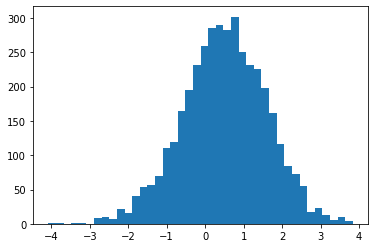

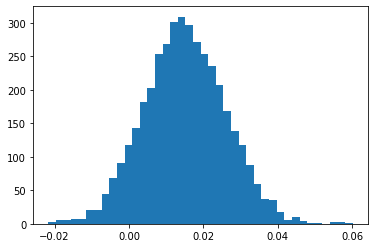

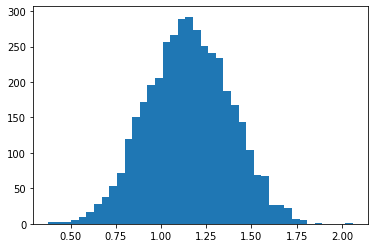

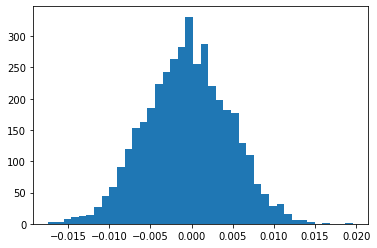

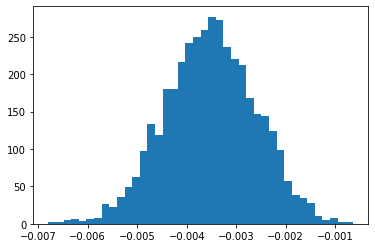

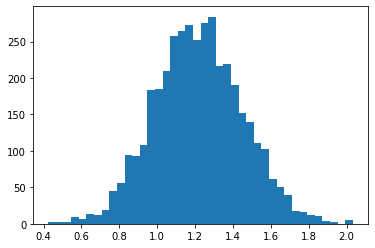

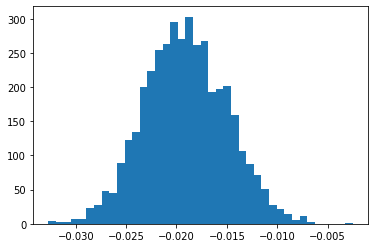

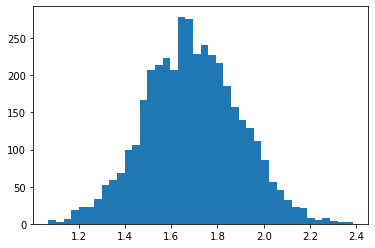

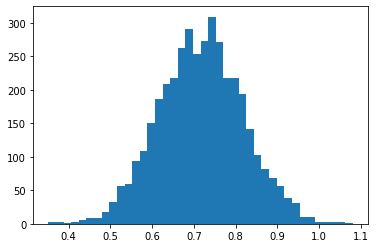

In [81]:
plt.hist(vars['alpha'], bins=40);
plt.show()
for i in range(vars['beta'].shape[1]):
    plt.hist(vars['beta'][:, i], bins=40);
    plt.show()

In [83]:
vars.keys()

dict_keys(['beta', 'alpha', 'theta'])

In [84]:
vars['theta']

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

/Users/leevi/.pyenv/versions/3.10.0/envs/bda-venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/leevi/.pyenv/versions/3.10.0/envs/bda-venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

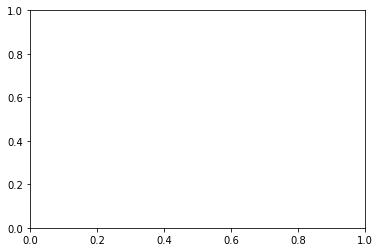

In [82]:
plt.hist(vars['theta'][:, 1], bins=40);